In [6]:
import tensorflow as tf
tf.enable_eager_execution()
import numpy as np
import pandas as pd

coor_data = pd.read_csv('Data/coordata.csv')
date_data = pd.read_csv('Data/datedata.csv')
meta_data = pd.read_csv('Data/metadata.csv')
bus_stop_data = pd.read_csv('Data/bus_stop.csv')

# general = pd.read_csv('Data/ScooterData_July15_Sept27_2019.csv')

data_set = coor_data.join(bus_stop_data.join(date_data.join(meta_data)))


Y_data = data_set[['endx', 'endy']].to_numpy()
X_data = data_set.drop(columns=['endx', 'endy','start_date', 'end_near_stop']).to_numpy()

In [7]:
import progressbar

X_sets_by_day = []
Y_sets_by_day = []

hr = 0
x = []
y = []

compare_hr_before = 0
compare_hr_current = 0
for i in progressbar.progressbar(range(len(X_data))):
    compare_hr_current = data_set['start_hour'][i]
    if (compare_hr_before == 23 and compare_hr_current == 0):
        hr = 0
        X_sets_by_day.append(x)
        Y_sets_by_day.append(y)
        x = []
        y = []
    compare_hr_before = data_set['start_hour'][i]
    x.append(X_data[i])
    y.append(Y_data[i])
    if i == (len(X_data) - 1):
        X_sets_by_day.append(x)
        Y_sets_by_day.append(y)

100% (459478 of 459478) |################| Elapsed Time: 0:00:08 Time:  0:00:08


In [30]:
X_train_set = []
Y_train_set = []
for i in progressbar.progressbar(range(48)):
    for j in range(len(X_sets_by_day[i])):
        X_train_set.append(X_sets_by_day[i][j])
        Y_train_set.append(Y_sets_by_day[i][j])

X_test_set = []
Y_test_set = []
for i in progressbar.progressbar(range(48,len(X_sets_by_day))):
    for j in range(len(X_sets_by_day[i])):
        X_test_set.append(X_sets_by_day[i][j])
        Y_test_set.append(Y_sets_by_day[i][j])
        
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.callbacks import EarlyStopping

X_train_set = np.array(X_train_set)
X_test_set = np.array(X_test_set)
scx = MinMaxScaler(feature_range=(0,1))
X_train_set_fit = scx.fit_transform(X_train_set)
X_test_set_fit = scx.transform(X_test_set)

Y_train_set = np.array(Y_train_set)
Y_test_set = np.array(Y_test_set)
scy = MinMaxScaler(feature_range=(0,1))
Y_train_set_fit = scy.fit_transform(Y_train_set)
Y_test_set_fit = scy.transform(Y_test_set)

100% (48 of 48) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (27 of 27) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [31]:
from tensorflow.keras import layers, Model, regularizers
from tensorflow.python.keras.layers.core import Dense, Activation, Dropout
from tensorflow.python.keras.layers.recurrent import LSTM

inputA = layers.Input(shape=(4))
inputB = layers.Input(shape=(60))

x = Dense(15)(inputA)
x = Dense(30)(x)
x = Model(inputs=inputA, outputs=x)
y = Dense(62)(inputB)
y = Dense(70, activation="relu")(y)
y = Model(inputs=inputB, outputs=y)

combined = layers.concatenate([x.output, y.output])

final = Dense(70, activation="softmax")(combined)
a = Dense(2)(final)


X_train_set_by_day = []
Y_train_set_by_day = []
X_test_set_by_day = []
Y_test_set_by_day = []
models = []

for day in range(7):
    X_train_set_by_day.append(X_train_set_fit[X_train_set[:,4] == day])
    Y_train_set_by_day.append(Y_train_set_fit[X_train_set[:,4] == day])
    X_test_set_by_day.append(X_test_set_fit[X_test_set[:,4] == day])
    Y_test_set_by_day.append(Y_test_set_fit[X_test_set[:,4] == day])
    models.append(Model(inputs=[x.input,y.input], outputs=a))
    models[day].compile(loss="mean_absolute_error", optimizer="adam")

# X_train_set_by_day.append(X_train_set_fit[X_train_set[:,4] < 5])
# Y_train_set_by_day.append(Y_train_set_fit[X_train_set[:,4] < 5])
# X_test_set_by_day.append(X_test_set_fit[X_test_set[:,4] < 5])
# Y_test_set_by_day.append(Y_test_set_fit[X_test_set[:,4] < 5])
# models.append(Model(inputs=[x.input,y.input], outputs=a))
# models[0].compile(loss="mean_absolute_error", optimizer="adam")

# X_train_set_by_day.append(X_train_set_fit[X_train_set[:,4] >= 5])
# Y_train_set_by_day.append(Y_train_set_fit[X_train_set[:,4] >= 5])
# X_test_set_by_day.append(X_test_set_fit[X_test_set[:,4] >= 5])
# Y_test_set_by_day.append(Y_test_set_fit[X_test_set[:,4] >= 5])
# models.append(Model(inputs=[x.input,y.input], outputs=a))
# models[1].compile(loss="mean_absolute_error", optimizer="adam")

In [39]:

x_train_old = []
y_train_old = []
for day in range(7):

    x_train = X_train_set_by_day[day]
    y_train = Y_train_set_by_day[day]
    
    models[day].fit([x_train[:,0:4],x_train[:,4:]], y_train, epochs=1, verbose=2)
#     x_train_old = X_train_set_by_day[day]
#     y_train_old = Y_train_set_by_day[day]
    for i in range(48,68):
        if X_sets_by_day[i][0][4] == day:
#             x_train = scx.transform(np.array(X_sets_by_day[i]))
#             y_train = scy.transform(np.array(Y_sets_by_day[i]))
            x = scx.transform(X_sets_by_day[i])
            y = scy.transform(Y_sets_by_day[i])
            X_train_set_by_day[day] = np.concatenate((X_train_set_by_day[day], x), axis=0)
            Y_train_set_by_day[day] = np.concatenate((Y_train_set_by_day[day], y), axis=0)
            
            
            x_train = X_train_set_by_day[day]
            y_train = Y_train_set_by_day[day]
            
            
            for j in range(7):
                if j != day and day < 5:
                    n = np.random.random_integers(0, len(Y_train_set_by_day[j]) - 1, size=(int(0.1*len(Y_train_set_by_day[j]))))
                    selection_x = X_train_set_by_day[j][n]
                    selection_y = Y_train_set_by_day[j][n]
                    x_train = np.concatenate((x_train, selection_x), axis=0)
                    y_train = np.concatenate((y_train, selection_y), axis=0)
            history = models[day].fit([x_train[:,0:4],x_train[:,4:]], y_train, epochs=100, verbose=2)
            print('current at: '+str(i))
#     for i in range(30,48):
#         if X_sets_by_day[i][0][4] < 5 and day == 0:
#             x_train = scx.transform(np.array(X_sets_by_day[i]))
#             y_train = scy.transform(np.array(Y_sets_by_day[i]))
#             history = models[0].fit([x_train[:,0:4],x_train[:,4:]], y_train, epochs=100, verbose=2)
#             print('current at: '+str(i))
#         elif X_sets_by_day[i][0][4] >= 5 and day == 1:
#             x_train = scx.transform(np.array(X_sets_by_day[i]))
#             y_train = scy.transform(np.array(Y_sets_by_day[i]))
#             history = models[1].fit([x_train[:,0:4],x_train[:,4:]], y_train, epochs=100, verbose=2)
#             print('current at: '+str(i))

66056/66056 - 2s - loss: 0.0179


I:\Users\PC\anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: This function is deprecated. Please call randint(0, 55405 + 1) instead
I:\Users\PC\anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: This function is deprecated. Please call randint(0, 63004 + 1) instead
I:\Users\PC\anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: This function is deprecated. Please call randint(0, 62161 + 1) instead
I:\Users\PC\anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: This function is deprecated. Please call randint(0, 71146 + 1) instead
I:\Users\PC\anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: This function is deprecated. Please call randint(0, 61475 + 1) instead
I:\Users\PC\anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: This function is deprecated. Please call randint(0, 52631

Epoch 1/100
109220/109220 - 3s - loss: 0.0180
Epoch 2/100
109220/109220 - 3s - loss: 0.0180
Epoch 3/100


KeyboardInterrupt: 

In [38]:
def haversine(coord1: object, coord2: object):
    import math

    # Coordinates in decimal degrees (e.g. 2.89078, 12.79797)
    lon1, lat1 = coord1
    lon2, lat2 = coord2

    R = 6371000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda / 2.0) ** 2
    
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    meters = R * c  # output distance in meters
    km = meters / 1000.0  # output distance in kilometers

    meters = round(meters, 5)
    km = round(km, 5)
    return km

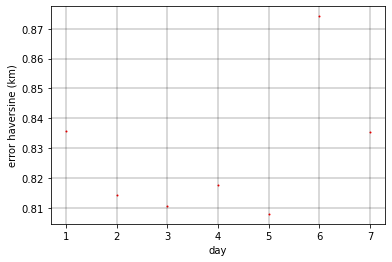

In [35]:
import matplotlib.pyplot as plt

sum_day = 0
plot_array_day = []
for day in range(7):
    x_test = X_test_set_by_day[day]
    y_test = Y_test_set_by_day[day]
    
    result_Y = models[day].predict([x_test[:,0:4],x_test[:,4:]])
    result_Y_all = scy.inverse_transform(result_Y)
    y_test_all = scy.inverse_transform(y_test)
    error_all = []
    for i in (range(len(y_test_all))):
        error_all.append(haversine(result_Y_all[i],y_test_all[i]))
    plot_array_day.append(error_all)   
    
# plt.xlabel('days of week')
# plt.ylabel('error haversine (km)')
# plt.boxplot(plot_array_day, showfliers=False) 

scat_plot = []
for day in range(len(plot_array_day)):
    scat_plot.append(sum(plot_array_day[day])/len(plot_array_day[day]))
plot_array_day = np.array(plot_array_day, dtype=np.object)
plt.xlabel('day')
plt.ylabel('error haversine (km)')
plt.grid(color='black', linestyle='-', linewidth=0.3)
plt.scatter([1,2,3,4,5,6,7], scat_plot, color='r', s= 1)

In [36]:
sum(scat_plot)/len(scat_plot)

0.8278975166149337

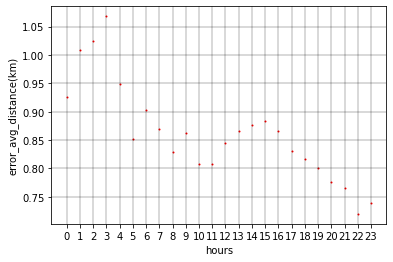

In [10]:
import matplotlib.pyplot as plt

mae_rate_hour = []

x_test_hour = scx.inverse_transform(x_test)

result_Y_hour = scy.inverse_transform(result_Y)
y_test_hour = scy.inverse_transform(y_test)
for index in range(24):
    mask = np.logical_and(x_test_hour[:,3] > (index)-0.2, x_test_hour[:,3] < (index+1)-0.2)
    result_Y_d = result_Y_hour[mask]
    Y_test_in = y_test_hour[mask]
    error = 0
    for i in range(len(Y_test_in)):
        error = error + haversine(result_Y_d[i,0:2],Y_test_in[i,0:2])
    end = error/len(Y_test_in)
    error_average_distance = end

    y_test[:,0] = y_test[:,0]
    mae_rate_hour.append([float(error_average_distance), str(index)])

mae_rate_hour = np.array(mae_rate_hour, dtype=np.object)
plt.xlabel('hours')
plt.ylabel('error_avg_distance(km)')
plt.grid(color='black', linestyle='-', linewidth=0.3)
plt.scatter(mae_rate_hour[:,1], mae_rate_hour[:,0], color='r', s= 1)

